In [1]:
# Deep convolutional GANs

# generator maps latent dims to images of shape (32,32,3)
# A discriminatory networkmaps it to binary
# a gan network chains the two together maps latent vectors for generator
# you train discriminator as any other classification model
# to train generator we use the genertaors weights with regard to loss of GAN model

# heuristics
# we use tanh as final activation
# we sample points using normal distribution
# Stochasticity s good to induce robustness
# Sparse gradients can hinder GAN training



In [3]:
# GAN generator network

import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

print(generator_input)
#First, transform the input into a 16x16 128 channel feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
print(x)

x = layers.LeakyReLU()(x)
x = layers.Reshape((16,16,128))(x)




Tensor("input_2:0", shape=(?, 32), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 32768), dtype=float32)


In [4]:
# Then we add a convolutional layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# a few more convolutional layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32x32 feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

In [6]:
# discriminator model

discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128,3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# one dropout layer
x = layers.Dropout(0.4)(x)

# classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6, 6, 128)         0   

In [7]:
# to stabilize training, we use the learning rate decay
# and gradient clipping(by value) in the optimizer

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

W0415 06:48:56.493244 14436 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# discriminator needs to be frozen while training gan
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [12]:
# now to train our DCGAN
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_,_) =  keras.datasets.cifar10.load_data()

# select images class 5
x_train = x_train[y_train.flatten()==6]

# normalize data
x_train = x_train.reshape(
        (x_train.shape[0],) + (height, width, channels)).astype('float32')/255.

iterations = 10000
batch_size = 20
save_dir = 'gan_images/'

# start training loop
start = 0
for step in range(iterations):
    #sample random points in the latent space 
    random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
    
    # decode them to fake images
    generated_images = generator.predict(random_latent_vectors)
    
    # combine them with real images
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # Assemble the labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size,1)),
                            np.zeros((batch_size,1))])
    
    # add random noise to sample
    labels += 0.05 * np.random.random(labels.shape)
    
    # train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
    
    # assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size,1))
    
    # train the generator via the gan model where discriminator is frozen
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if(start > len(x_train) - batch_size):
        start = 0
    
    # occasionally save / plot
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        
        print("discriminator loss ",step, " : ",d_loss )
        print("adverserial loss ", step, " : ", a_loss)
        
        # save one generated image
        img = image.array_to_img(generated_images[0] * 255.,scale=False )
        img.save (os.path.join(save_dir, 'generated_five' + str(step) + '.png'))
        
        #save real image for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_five' + str(step) + '.png'))

discriminator loss  0  :  2.570611
adverserial loss  0  :  1.1747212e-10
discriminator loss  100  :  0.6671761
adverserial loss  100  :  0.72095984
discriminator loss  200  :  0.69631994
adverserial loss  200  :  0.78984845
discriminator loss  300  :  0.6973946
adverserial loss  300  :  0.6830341
discriminator loss  400  :  0.6878629
adverserial loss  400  :  0.72458524
discriminator loss  500  :  0.69315773
adverserial loss  500  :  0.7355903
discriminator loss  600  :  0.6852975
adverserial loss  600  :  0.72025377
discriminator loss  700  :  0.67483103
adverserial loss  700  :  0.6131543
discriminator loss  800  :  0.69806916
adverserial loss  800  :  0.77024883
discriminator loss  900  :  0.7076731
adverserial loss  900  :  0.80403054
discriminator loss  1000  :  0.6961865
adverserial loss  1000  :  0.75396615
discriminator loss  1100  :  0.70116633
adverserial loss  1100  :  0.80903137
discriminator loss  1200  :  0.6854866
adverserial loss  1200  :  0.7595445
discriminator loss  

In [19]:
!pip install scikit-image

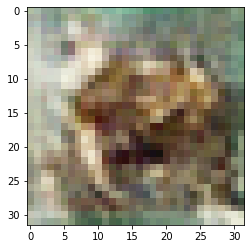

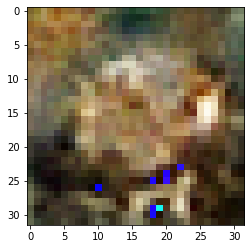

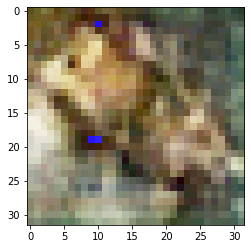

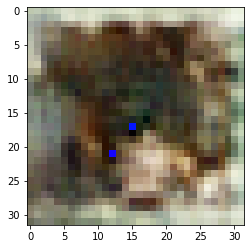

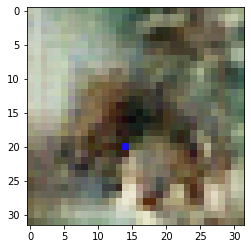

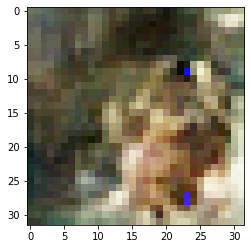

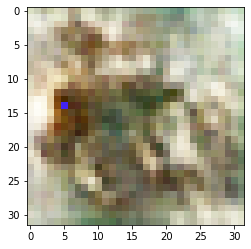

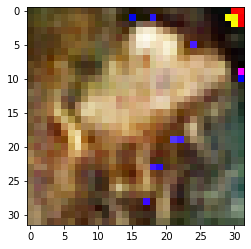

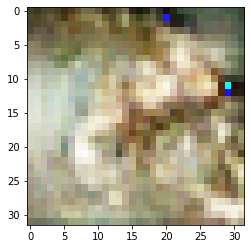

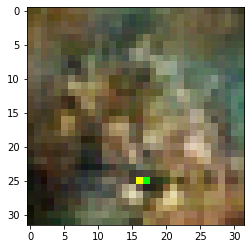

In [22]:
import matplotlib.pyplot as plt
from skimage.transform import rescale

# sample random points on latent space
random_latent_vectors = np.random.normal(size=(10,latent_dim))

# decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    # rescaling
    #img = rescale(img, (image.shape[0] // 4, image.shape[1] //4), anti_aliasing=True)
    plt.figure()
    plt.imshow(img)

plt.show()